# Bar Charts

[Matplotlib Tutorial#Bar Plots](http://www.labri.fr/perso/nrougier/teaching/matplotlib/#bar-plots)

In Vega-lite 2, it is not possible to build a chart in which two positive variables are plotted as bars, with the bars going in opposite directions. To do this, one of the variables needs to be scaled by -1.

In [1]:
# Imports
import numpy as np
import pandas as pd
import altair as alt
import altair.vega.v3 as vega

# For inspecting Altair/Vega structures
import json

import copy

In [2]:
# Create Data
n = 12
x = np.arange(n)
y1 = (1-x/float(n)) * np.random.uniform(0.5, 1.0, n)
# scale y2 by -1 to get the bars going in the opposite direction
y2 = (1-x/float(n)) * np.random.uniform(0.5, 1.0, n)
df = pd.DataFrame({'x':x, 'y1':y1, 'y2':y2}).melt('x')
df.head()

,x,variable,value
0,0,y1,0.884916
1,1,y1,0.754377
2,2,y1,0.441312
3,3,y1,0.736333
4,4,y1,0.484930


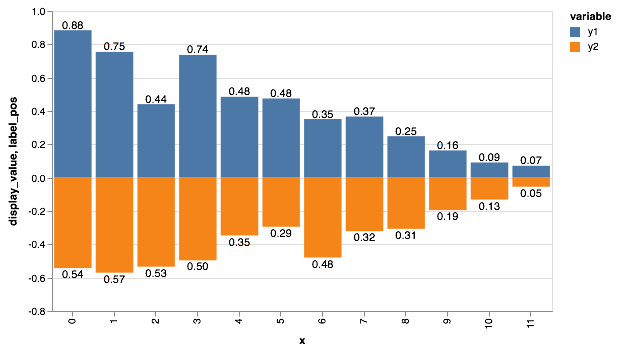

In [3]:
bars = alt.Chart(width=500).mark_bar().encode(
    x='x:N', 
    y='display_value:Q', 
    color=alt.Color('variable')
).transform_calculate(
    display_value='datum.variable == "y1" ? datum.value : datum.value * -1',
)
text = alt.Chart(width=500).mark_text(
    align='center',
    baseline='bottom',
).encode(
    x='x:N', y='label_pos:Q',
    text='label:N'
).transform_calculate(
    label_pos='datum.variable === "y1" ? datum.value : -1 * (datum.value + 0.07)',
    label='format(datum.value, ".2f")'
)
alt.layer(bars, text, data=df)

It is possible, though, to build a bar chart with two positive variables mapped in different directions in Vega 3.

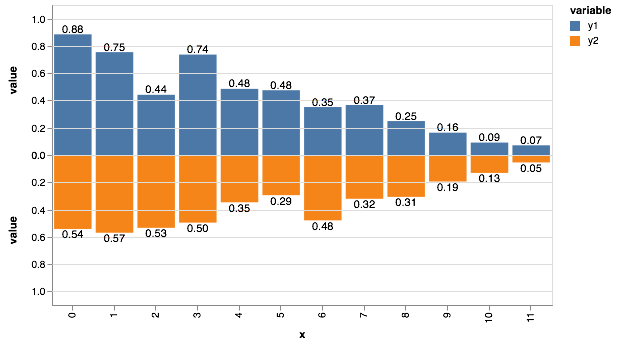

In [5]:
y_domain = [0, 1.1]
bar = {
  "type": "rect",
  "style": ["bar"],
  "encode": {
    "update": {
      "fill": {"scale": "color", "field": "variable"},
      "x": {"scale": "x", "field": "x"},
      "width": {"scale": "x", "band": True},
      "y": {"scale": "y", "field": "value_end"},
      "y2": {"scale": "y", "field": "value_start"}
    }
  }
}
label = {
  "type": "text",
  "style": ["text"],
  "encode": {
    "update": {
      "align": {"value": "center"},
      "baseline": {"value": "bottom"},
      "fill": {"value": "black"},
      "x": {"scale": "x", "field": "x", "band": 0.5},
      "y": {"scale": "y", "signal": "datum.value"},
      "text": {"signal": "format(datum.value, '.2f')"}
    }
  },
  "zindex": 2
}
y1_bar = copy.deepcopy(bar)
y1_bar['name'] = 'y1_bar'
y1_bar['from'] = {"data": "y1"}
y1_label = copy.deepcopy(label)
y1_label['name'] = 'y1_label'
y1_label['from'] = {"data": "y1"}
y1_label['encode']['update']['baseline']['value'] = 'bottom'

y2_bar = copy.deepcopy(bar)
y2_bar['name'] = 'y2_bar'
y2_bar['from'] = {"data": "y2"}
y2_label = copy.deepcopy(label)
y2_label['name'] = 'y2_label'
y2_label['from'] = {"data": "y2"}
y2_label['encode']['update']['baseline']['value'] = 'top'

y_group_axes = [
    {
      "scale": "y",
      "orient": "left",
      "title": "value",
      "tickCount": {"signal": "ceil(height/80)"},
      "zindex": 1
    },
    {
      "scale": "y",
      "orient": "left",
      "grid": True,
      "tickCount": {"signal": "ceil(height/80)"},
      "gridScale": "x",
      "domain": False,
      "labels": False,
      "maxExtent": 0,
      "minExtent": 0,
      "ticks": False,
      "zindex": 1
    }
]

spec = {
  "$schema": "https://vega.github.io/schema/vega/v3.0.json",
  "autosize": "pad",
  "padding": 5,
  "width": 500,
  "height": 300,
  "style": "cell",
  "data": [
    {
      "name": "population",
      "values": df.apply(lambda x: x.to_dict(), 1).tolist()
    },
    {
      "name": "data_1",
      "source": "population",
      "transform": [
        {
          "type": "formula",
          "expr": "toNumber(datum[\"value\"])",
          "as": "value"
        },
        {
          "type": "stack",
          "groupby": ["x", "variable"],
          "field": "value",
          "sort": {"field": ["variable"], "order": ["descending"]},
          "as": ["value_start", "value_end"],
          "offset": "zero"
        },
        {
          "type": "filter",
          "expr": "datum[\"value\"] !== null && !isNaN(datum[\"value\"])"
        }
      ]
    },
    {
      "name": "y1",
      "source": "data_1",
      "transform": [
        {
          "type": "filter",
          "expr": "datum.variable === 'y1'"
        }
      ]
    },
    {
      "name": "y2",
      "source": "data_1",
      "transform": [
        {
          "type": "filter",
          "expr": "datum.variable === 'y2'"
        }
      ]
    }
  ],
  "marks": [
    {
      "type": "group",
      "scales": [
        {
          "name": "y",
          "type": "linear",
          "domain": y_domain,
          "range": [{"signal": "height/2"}, 0],
          "nice": True,
          "zero": True
        }
      ],
      "marks": [y1_bar, y1_label],
      "axes": y_group_axes
    },
    {
      "type": "group",
      "scales": [
        {
          "name": "y",
          "type": "linear",
          "domain": y_domain,
          "range": [{"signal": "height/2"}, {"signal": "height"}],
          "nice": True,
          "zero": True
        }
      ],
      "axes": y_group_axes,
      "marks": [y2_bar, y2_label]
    }
  ],
  "scales": [
    {
      "name": "x",
      "type": "band",
      "domain": {
        "fields": [
          {"data": "data_1", "field": "x"}
        ],
        "sort": True
      },
      "range": [0, {"signal": "width"}],
      "paddingInner": 0.1,
      "paddingOuter": 0.05
    },
    {
      "name": "color",
      "type": "ordinal",
      "domain": {"data": "data_1", "field": "variable", "sort": True},
      "range": "category"
    }
  ],
  "axes": [
    {
      "scale": "x",
      "orient": "bottom",
      "title": "x",
      "encode": {
        "labels": {
          "update": {
            "angle": {"value": 270},
            "align": {"value": "right"},
            "baseline": {"value": "middle"}
          }
        }
      },
      "zindex": 1
    }
  ],
  "legends": [
    {
      "fill": "color",
      "title": "variable",
      "encode": {"symbols": {"update": {"shape": {"value": "square"}}}}
    }
  ],
  "config": {"axisY": {"minExtent": 30}}
}
vega.vega(spec)